In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 98% 118M/121M [00:06<00:00, 20.0MB/s]
100% 121M/121M [00:07<00:00, 17.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
types_of_images={}

image_folder = '/content/images/images'

types_of_images = {}
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.jpg','.jpeg', '.png', '.bmp')):
            img_path = os.path.join(root, file)
            if file.split('.')[-1] in types_of_images:
              types_of_images[file.split('.')[-1]]+=1
            else:
              types_of_images[file.split('.')[-1]]=1

types_of_images

{'jpg': 35887}

In [ ]:
import os
import cv2

def check_image(img_path):
  img = cv2.imread(img_path)
  if img is None:
      print(f"Error: Unable to read image - {img_path}")
      return

  if img.shape[2] == 1:  # Grayscale image
      print(f"Warning: Grayscale image - {img_path}")
  elif img.shape[2] == 3:  # RGB image
      pass
  elif img.shape[2] == 4:  # RGBA image
      print(f"Warning: RGBA image with transparency - {img_path}")
  else:
      print(f"Error: Unsupported image format - {img_path}")

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.jpg','.jpeg', '.png', '.bmp')):
            img_path = os.path.join(root, file)
            check_image(img_path)

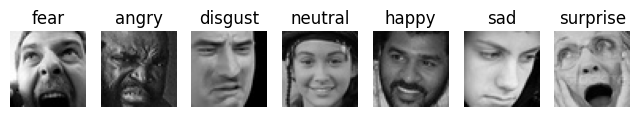

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

i = 1
plt.figure(figsize=(8, 8))
for expression in os.listdir('/content/images/validation/'):
    img = load_img(('/content/images/validation/' + expression + '/' + os.listdir('/content/images/validation/' + expression)[0]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('/content/images/train',
    target_size=(48,48),
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=128,
    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255.0)

val_data = val_datagen.flow_from_directory('/content/images/validation',
                                           target_size=(48,48),
                                           class_mode='categorical',
                                            color_mode='grayscale',
                                           batch_size=128,
                                           shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 6, 6, 128)       

In [ ]:
history = model.fit(train_data, epochs=100, steps_per_epoch=225, verbose = 1,validation_data=val_data)

Epoch 1/100
225/225 [==============================] - 16s 59ms/step - loss: 1.8355 - accuracy: 0.2299 - val_loss: 1.8112 - val_accuracy: 0.2583
Epoch 2/100
225/225 [==============================] - 13s 58ms/step - loss: 1.8228 - accuracy: 0.2339 - val_loss: 1.7857 - val_accuracy: 0.2583
Epoch 3/100
225/225 [==============================] - 13s 57ms/step - loss: 1.7991 - accuracy: 0.2525 - val_loss: 1.7977 - val_accuracy: 0.2505
Epoch 4/100
225/225 [==============================] - 9s 42ms/step - loss: 1.7900 - accuracy: 0.2597 - val_loss: 1.7723 - val_accuracy: 0.2591
Epoch 5/100
225/225 [==============================] - 10s 45ms/step - loss: 1.7760 - accuracy: 0.2544 - val_loss: 1.7758 - val_accuracy: 0.2646
Epoch 6/100
225/225 [==============================] - 10s 43ms/step - loss: 1.7496 - accuracy: 0.2789 - val_loss: 1.7094 - val_accuracy: 0.3112
Epoch 7/100
225/225 [==============================] - 13s 58ms/step - loss: 1.7053 - accuracy: 0.3083 - val_loss: 1.6666 - val_acc

In [ ]:
model_json = model.to_json()
json_file = 'emotiondetector.json'
with open(json_file,'w') as f:
  f.write(model_json)
model.save('emotiondetector.h5')

In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('/content/emotiondetector.json','r')
model_json=json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights('/content/emotiondetector.h5')

In [ ]:
import cv2
haar = cv2.data.haarcascades+'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar)

In [ ]:
import numpy as np
def feature_extract(img):
  feature = np.array(img)
  feature.reshape(1,48,48,1)
  return feature/255.0

In [ ]:
cap = cv2.VideoCapture(0)
labels = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'suprise'}

while True:
  success,frame=cap.read()
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(frame,1.3,5)

  for (p,q,r,s) in faces:
    image = gray[q:q+s,p:p+r]
    cv2.rectangle(frame,(p,q),(p+r,q+s),(255,0,0),2)
    image = cv2.resize(image,(48,48))
    img = feature_extract(image)

    pred = model.predict(img)

    prediction_label = labels[pred.argmax()]

    cv2.putText(frame, '% s' %(prediction_label),(p-10,q-10),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255))

    cv2.imshow('Output',frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
